# h

hola

In [62]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import numpy as np

In [64]:
print(os.getcwd())

C:\Users\Liliana\Documents\Scripts_Python\Pivotes\pivotes


In [65]:
# Define las rutas de los archivos
ruta_base = r'C:\Users\Liliana\OneDrive - Universidad Nacional de Colombia\Documentos\Scripts_Python'
print(ruta_base)



C:\Users\Liliana\OneDrive - Universidad Nacional de Colombia\Documentos\Scripts_Python


# 1. Carga y Exploración datos

## 1.1. Ubicación Pivotes

In [70]:
ruta_pivots =ruta_base+r'\Pivotes\csv_data\pivots_coordinates.csv'

df_pivots = pd.read_csv(ruta_pivots, sep=';', decimal=',')
print("\nTabla de Pivots Coordinates:")
print(df_pivots)
print(df_pivots.dtypes)



Tabla de Pivots Coordinates:
   Punto   Latitud   Longitud
0     P1  3.364976 -76.365656
1     P2  3.357936 -76.373861
2     P3  3.556528 -76.401532
3     P4  3.575447 -76.340913
4     P5  3.428722 -76.234224
5     P6  3.561619 -76.348976
6     P7  3.582757 -76.374203
7     P8  3.565692 -76.344612
8     P9  3.624155 -76.290373
9    P10  3.580165 -76.361310
10   P11  3.578169 -76.314043
11   P12  3.425594 -76.345367
Punto        object
Latitud     float64
Longitud    float64
dtype: object


### 1.1.1. Exportar puntos de pivote a shapefile

# Crear geometrías de puntos a partir de latitud y longitud
geometry = [Point(xy) for xy in zip(df_pivots['Longitud'], df_pivots['Latitud'])]

# Crear un GeoDataFrame
gdf = gpd.GeoDataFrame(df_pivots, geometry=geometry)

# Asignar sistema de coordenadas WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)


# Ruta para guardar el shapefile
carpeta_salida = r'C:\Users\Liliana\OneDrive - Universidad Nacional de Colombia\Documentos\Scripts_Python\Pivotes\output'
salida_shapefile = os.path.join(carpeta_salida, 'pivots_coordinates.shp')

# Crear la carpeta si no existe
if not os.path.exists(carpeta_salida):
    os.makedirs(carpeta_salida)

# Exportar a shapefile
gdf.to_file(salida_shapefile, driver='ESRI Shapefile')

print(f"Shapefile creado exitosamente: {salida_shapefile}")

# Exportar a shapefile
salida_shapefile = r'C:\Users\Liliana\OneDrive - Universidad Nacional de Colombia\Documentos\Scripts_Python\Pivotes\output\pivots_coordinates.shp'
gdf.to_file(salida_shapefile, driver='ESRI Shapefile')

print(f"Shapefile creado exitosamente: {salida_shapefile}")

## 1.2. Distancias y láminas

### 1.2.1. Tidy data

In [385]:
import pandas as pd

# Cargar el archivo
ruta_distances = ruta_base + r'\Pivotes\csv_data\distances.csv'
df_distances = pd.read_csv(ruta_distances, sep=';')

# Asegurar que las columnas de pivotes están en el formato correcto
columnas_pivotes = df_distances.columns.drop('Distancia (m)')
df_distances[columnas_pivotes] = df_distances[columnas_pivotes].replace(',', '.', regex=True)
df_distances[columnas_pivotes] = df_distances[columnas_pivotes].apply(pd.to_numeric, errors='coerce')

# Normalizamos el DataFrame al formato tidy
df_tidy = pd.melt(
    df_distances,
    id_vars=["Distancia (m)"],  # Identificadores que no se transforman
    value_vars=columnas_pivotes,  # Columnas que se transforman
    var_name="Pivote",  # Nombre para la columna de pivotes
    value_name="Lamina"  # Nombre para los valores
)


# Renombramos la columna 'Distancia (m)' a 'Distancia'
df_tidy.rename(columns={'Distancia (m)': 'Distancia'}, inplace=True)

# Visualizamos las primeras filas del DataFrame tidy
print(df_tidy.head(5))
df_original=df_tidy.copy()
print(df_original.head(5))

   Distancia Pivote     Lamina
0          3     P1  13.926058
1          6     P1  13.130283
2          9     P1   7.559860
3         12     P1   2.387324
4         15     P1   7.559860
   Distancia Pivote     Lamina
0          3     P1  13.926058
1          6     P1  13.130283
2          9     P1   7.559860
3         12     P1   2.387324
4         15     P1   7.559860


### 1.2.1. Representar las distancias y caudales en un gráfico

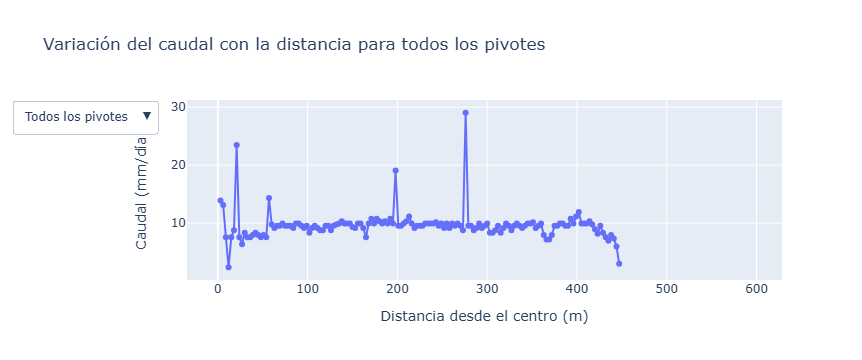

In [78]:
import plotly.graph_objects as go

# Crear una figura base
fig = go.Figure()

# Agregar una traza para cada pivote
pivotes = df_tidy['Pivote'].unique()
for pivote in pivotes:
    datos_pivote = df_tidy[df_tidy['Pivote'] == pivote]
    fig.add_trace(go.Scatter(
        x=datos_pivote['Distancia'], 
        y=datos_pivote['Lamina'],
        mode='lines+markers',
        name=pivote,
        visible=True if pivote == pivotes[0] else False  # Mostrar solo el primer pivote al inicio
    ))

# Crear botones para el menú desplegable
buttons = [
    {
        'label': 'Todos los pivotes',
        'method': 'update',
        'args': [
            {'visible': [True] * len(pivotes)},  # Mostrar todas las trazas
            {'title': 'Variación del caudal con la distancia para todos los pivotes'}
        ]
    }
] + [
    {
        'label': pivote,
        'method': 'update',
        'args': [
            {'visible': [p == pivote for p in pivotes]},  # Solo mostrar el pivote seleccionado
            {'title': f'Variación del caudal con la distancia para el pivote {pivote}'}
        ]
    }
    for pivote in pivotes
]

# Agregar el menú a la figura
fig.update_layout(
    updatemenus=[
        {
            'buttons': buttons,
            'direction': 'down',  # Desplegable hacia abajo
            'showactive': True,   # Resaltar la opción activa
        }
    ]
)

# Configuración de los ejes y título inicial
fig.update_layout(
    title='Variación del caudal con la distancia para todos los pivotes',
    xaxis_title='Distancia desde el centro (m)',
    yaxis_title='Caudal (mm/día)',
    legend_title='Pivote'
)

# Mostrar la figura
fig.show()


# 2. Cálculo índices uniformidad

In [410]:
df_tidy=df_original.copy()
print(df_tidy)


      Distancia Pivote     Lamina
0             3     P1  13.926058
1             6     P1  13.130283
2             9     P1   7.559860
3            12     P1   2.387324
4            15     P1   7.559860
...         ...    ...        ...
2359        579    P12        NaN
2360        582    P12        NaN
2361        585    P12        NaN
2362        588    P12        NaN
2363        591    P12        NaN

[2364 rows x 3 columns]


In [412]:
# Crear la nueva columna dividiendo 'Caudal' entre 24
df_tidy['Lamina_L_m2_h'] = df_tidy['Lamina'] / 24

# Verificar los primeros registros para confirmar la nueva columna
print(df_tidy.head())

   Distancia Pivote     Lamina  Lamina_L_m2_h
0          3     P1  13.926058       0.580252
1          6     P1  13.130283       0.547095
2          9     P1   7.559860       0.314994
3         12     P1   2.387324       0.099472
4         15     P1   7.559860       0.314994


## 2.1. Cálculo índice Christiansen

In [415]:
# Asegúrate de que ya se hayan calculado las estadísticas
estadisticas_por_pivote = df_tidy.groupby('Pivote')['Lamina_L_m2_h'].agg(['mean', 'std'])

# Renombrar temporalmente el promedio para evitar conflictos al hacer el merge
estadisticas_por_pivote = estadisticas_por_pivote.rename(columns={'mean': 'media'})

# Unir el promedio al DataFrame original
df_tidy = df_tidy.merge(
    estadisticas_por_pivote[['media']],  # Seleccionar solo la columna de promedio temporal
    on='Pivote',                                    # Unir por la columna 'Pivote'
    how='left'                                      # Mantener todas las filas de df_tidy
)

# Calcular la diferencia absoluta
df_tidy['Diferencia_absoluta'] = abs(df_tidy['Lamina_L_m2_h'] - df_tidy['media'])

# Eliminar la columna temporal para evitar confusión
df_tidy.drop(columns=['media'], inplace=True)

# Verificar las primeras filas para confirmar los resultados
print(df_tidy.head())


   Distancia Pivote     Lamina  Lamina_L_m2_h  Diferencia_absoluta
0          3     P1  13.926058       0.580252             0.180640
1          6     P1  13.130283       0.547095             0.147483
2          9     P1   7.559860       0.314994             0.084618
3         12     P1   2.387324       0.099472             0.300140
4         15     P1   7.559860       0.314994             0.084618


In [416]:
# Crear la columna con la suma acumulativa de las diferencias absolutas por pivote
df_tidy['Suma_diferencias'] = df_tidy.groupby('Pivote')['Diferencia_absoluta'].transform('sum')

# Calcular y almacenar la suma total de las diferencias absolutas para cada pivote
suma_por_pivote = df_tidy.groupby('Pivote')['Diferencia_absoluta'].sum()

# Mostrar los primeros registros del DataFrame con la nueva columna
print(df_tidy.head())

# Mostrar la suma total de diferencias absolutas por pivote
print("\nSuma total de diferencias absolutas por pivote:")
print(suma_por_pivote)

   Distancia Pivote     Lamina  Lamina_L_m2_h  Diferencia_absoluta  \
0          3     P1  13.926058       0.580252             0.180640   
1          6     P1  13.130283       0.547095             0.147483   
2          9     P1   7.559860       0.314994             0.084618   
3         12     P1   2.387324       0.099472             0.300140   
4         15     P1   7.559860       0.314994             0.084618   

   Suma_diferencias  
0          7.004754  
1          7.004754  
2          7.004754  
3          7.004754  
4          7.004754  

Suma total de diferencias absolutas por pivote:
Pivote
P1      7.004754
P10     5.840418
P11     8.470964
P12    13.994906
P2      6.658806
P3     16.993680
P4     18.740621
P5      8.724909
P6      6.449091
P7     10.624358
P8      5.641285
P9     16.431452
Name: Diferencia_absoluta, dtype: float64


In [419]:
# Calcular el número total de medidas y el promedio por pivote en una sola operación
estadisticas = df_tidy.groupby('Pivote')['Lamina_L_m2_h'].agg(
    cantidad='count',
    promedio='mean', 
    desv_std="std"
)

# Calcular el índice de Christiansen (CUC) para cada pivote
estadisticas['CUC'] = (1 - (suma_por_pivote / (estadisticas['cantidad'] * estadisticas['promedio']))) * 100

# Crear el DataFrame final con los resultados del CUC
indices_uniformidad = estadisticas[['CUC']].reset_index()

#Elimino columna temporal creada en estadistics
estadisticas.drop(columns=['CUC'], inplace=True)

# Mostrar los resultados
print("\nÍndice de Christiansen (CUC) por pivote:")
print(indices_uniformidad)




Índice de Christiansen (CUC) por pivote:
   Pivote        CUC
0      P1  88.235646
1     P10  91.131889
2     P11  89.021132
3     P12  77.945059
4      P2  89.913367
5      P3  75.356635
6      P4  59.092854
7      P5  87.756796
8      P6  86.721283
9      P7  81.176497
10     P8  91.348226
11     P9  80.711845


## 2.2. Cálculo Wilcox & Swailes

In [421]:
# Calcular el índice de Wilcox & Swailes (CUE)
estadisticas['CUE'] = 100*(1 - (estadisticas['desv_std'] / estadisticas['promedio']))


# Agregar el CUE al DataFrame indices_uniformidad
indices_uniformidad = indices_uniformidad.merge(
    estadisticas[['CUE']].reset_index(),
    on='Pivote',
    how='left'
)
#Elimino columna temporal creada en estadisti
estadisticas.drop(columns=['CUE'], inplace=True)
# Mostrar los resultados
print("\nÍndice de Uniformidad (CUE) por pivote:")
print(indices_uniformidad)




Índice de Uniformidad (CUE) por pivote:
   Pivote        CUC        CUE
0      P1  88.235646  73.487742
1     P10  91.131889  83.881097
2     P11  89.021132  86.448090
3     P12  77.945059  59.241936
4      P2  89.913367  85.851134
5      P3  75.356635  54.858622
6      P4  59.092854  10.422018
7      P5  87.756796  76.760318
8      P6  86.721283  79.948773
9      P7  81.176497  75.024418
10     P8  91.348226  86.322456
11     P9  80.711845  69.225384


In [422]:
print("estadisticas", estadisticas)

estadisticas         cantidad  promedio  desv_std
Pivote                              
P1           149  0.399612  0.105946
P10           98  0.672027  0.108323
P11          184  0.419331  0.056827
P12          157  0.404170  0.164732
P2           177  0.372973  0.052771
P3           143  0.482227  0.217684
P4            92  0.497963  0.446065
P5           197  0.361743  0.084068
P6           155  0.313336  0.062828
P7           156  0.361808  0.090364
P8           175  0.372593  0.050962
P9           197  0.432433  0.133080


## 2.3. Cálculo de  Criddle CUD

In [427]:
# Ordenar el DataFrame por 'Pivote' y 'Distancia'
df_tidy.sort_values(by=['Pivote', 'Distancia'], inplace=True)

# Crear la columna 'cum_L_m2_h' calculando la suma acumulada dividida por el número acumulado de registros
df_tidy['cum_L_m2_h'] = df_tidy.groupby('Pivote')['Lamina_L_m2_h'].transform(
    lambda x: x.cumsum() / (np.arange(1, len(x) + 1))
)
print("df_tidy 8 ", df_tidy)
# Crear la columna 'n_25' en el DataFrame estadisticas
estadisticas['n_25'] = (estadisticas['cantidad'] * 0.25).round(0).astype(int)

# Resetear índices para asegurar el merge y evitar conflictos
df_tidy_reset = df_tidy.reset_index(drop=True)

estadisticas = estadisticas.reset_index(drop=False)

# Crear un índice temporal para el merge
df_tidy_reset['temp_index'] = df_tidy_reset.groupby('Pivote').cumcount() + 1
print("df_tidy_reset 18",df_tidy_reset)


print("estadisticas 22",estadisticas)
# Crear un DataFrame con los valores de 'cum_L_m2_h' correspondientes a 'n_25'
resultados_index = estadisticas.merge(
    df_tidy_reset,
    left_on=['Pivote', 'n_25'],
    right_on=['Pivote', 'temp_index'],
    how='left',
    suffixes=('_estadisticas', '_tidy')  # Evitar colisiones de nombres
)[['Pivote', 'cum_L_m2_h']]

print("",)
# Renombrar la columna 'cum_L_m2_h' a 'X_25'
resultados_index.rename(columns={'cum_L_m2_h': 'X_25'}, inplace=True)

# Unir el DataFrame 'resultados_index' con 'estadisticas_reset'
estadisticas = estadisticas.merge(
    resultados_index,
    on='Pivote',
    how='left'
)
print("estadisticas 39",estadisticas)
# Calcular el índice CUD en base a 'X_25' y 'promedio'
estadisticas['CUD'] = (estadisticas['X_25'] / estadisticas['promedio']) * 100

# Asegurar que las columnas de unión son del mismo tipo para evitar errores
indices_uniformidad['Pivote'] = indices_uniformidad['Pivote'].astype(estadisticas['Pivote'].dtype)

# Unir el índice CUD al DataFrame indices_uniformidad
indices_uniformidad = indices_uniformidad.merge(
    estadisticas[['Pivote', 'CUD']],
    on='Pivote',
    how='left'
)
#Eliminar campo CUD en estadísticas
estadisticas.drop(columns=['CUD'], inplace=True)
# Mostrar los resultados finales
print("Estadísticas actualizadas con X_25 y CUD:")
print("estadisticas", estadisticas)
print("\nÍndices de uniformidad actualizados:")
print(indices_uniformidad)



df_tidy 8        Distancia Pivote     Lamina  Lamina_L_m2_h  Diferencia_absoluta  \
0             3     P1  13.926058       0.580252             0.180640   
1             6     P1  13.130283       0.547095             0.147483   
2             9     P1   7.559860       0.314994             0.084618   
3            12     P1   2.387324       0.099472             0.300140   
4            15     P1   7.559860       0.314994             0.084618   
...         ...    ...        ...            ...                  ...   
1768        579     P9   4.973592       0.207233             0.225200   
1769        582     P9   8.554578       0.356441             0.075992   
1770        585     P9  11.140846       0.464202             0.031769   
1771        588     P9   9.947184       0.414466             0.017967   
1772        591     P9   9.151409       0.381309             0.051124   

      Suma_diferencias  cum_L_m2_h  
0             7.004754    0.580252  
1             7.004754    0.563674  
2

## 2.4. Cálculo CUA (Karmelli & Keller)

In [432]:
# 2.4. Cálculo CUA (Karmelli & Keller)
print("df_tudy 2", df_tidy)
# Ordenar por Pivote y Distancia de mayor a menor para calcular la suma acumulada inversa
df_tidy['max_cum_L_m2_h'] = (
    df_tidy.sort_values(by=['Pivote', 'Distancia'], ascending=[True, False])
          .groupby('Pivote')['Lamina_L_m2_h']
          .cumsum()
)
print("df_tudy 9", df_tidy)

# Crear la columna 'n_125' en estadisticas como 12.5% de cantidad redondeado
estadisticas['n_125'] = (estadisticas['cantidad'] * 0.125).round(0).astype(int)
# Resetear índices para asegurar el merge y evitar conflictos
df_tidy= df_tidy.reset_index(drop=True)
estadisticas= estadisticas.reset_index(drop=True)

print("estadisticas17",estadisticas)
print("df_tudy 18", df_tidy)


print("df_tudy 20", df_tidy)


# Crear un índice temporal para el merge
df_tidy['temp_index'] = df_tidy.groupby('Pivote').cumcount() + 1
print("df_tidy 19",df_tidy)

# Dividir df_tidy['max_cum_L_m2_h'] entre la cantidad mapeada
df_tidy['prom_max'] = df_tidy['max_cum_L_m2_h'] / (df_tidy['cantidad'])

print("df_tudy 30", df_tidy)



# Crear índice temporal para cada Pivote en df_tidy
df_tidy['relative_index'] = df_tidy.groupby('Pivote').cumcount()

print("df_tidy cantidAD 19",df_tidy['cantidad'])
# Calcular adjusted_max_cum_L_m2_h dividiendo max_cum_L_m2_h entre la resta entre cantidad y el índice temporal
df_tidy['adjusted_max_cum_L_m2_h'] = df_tidy['max_cum_L_m2_h'] / (df_tidy['cantidad'] - df_tidy['relative_index'])

# Inicializar lista para almacenar resultados de x_125max
x_125max_results = []

# Iterar sobre cada pivote y calcular el valor equivalente a INDEX(G8:G156;B1-L1+1)
for pivote, cantidad, n_125 in zip(estadisticas.index, estadisticas['cantidad'], estadisticas['n_125']):
    # Filtrar datos para el pivote actual
    datos_pivote = df_tidy[df_tidy['Pivote'] == pivote]
    
    # Calcular el índice (B1 - L1 + 1)
    indice = int(cantidad - n_125)  # Restar n_125 de cantidad y convertir a entero
    
    # Verificar si el índice está dentro del rango
    if 1 <= indice <= len(datos_pivote):
        # Extraer el valor de adjusted_max_cum_L_m2_h
        valor = datos_pivote.iloc[indice - 1]['adjusted_max_cum_L_m2_h']  # Restar 1 por índices 0-based
        x_125max_results.append(valor)
    else:
        # Si está fuera de rango, asignar None
        x_125max_results.append(None)

# Agregar resultados a la columna x_125max en estadisticas
estadisticas['x_125max'] = x_125max_results

# Mostrar resultados finales
print("Estadísticas con x_125max:")
print(estadisticas)


df_tudy 2       Distancia Pivote     Lamina  Lamina_L_m2_h  Diferencia_absoluta  \
0             3     P1  13.926058       0.580252             0.180640   
1             6     P1  13.130283       0.547095             0.147483   
2             9     P1   7.559860       0.314994             0.084618   
3            12     P1   2.387324       0.099472             0.300140   
4            15     P1   7.559860       0.314994             0.084618   
...         ...    ...        ...            ...                  ...   
2359        579     P9   4.973592       0.207233             0.225200   
2360        582     P9   8.554578       0.356441             0.075992   
2361        585     P9  11.140846       0.464202             0.031769   
2362        588     P9   9.947184       0.414466             0.017967   
2363        591     P9   9.151409       0.381309             0.051124   

      Suma_diferencias  cum_L_m2_h  max_cum_L_m2_h  temp_index  
0             7.004754    0.580252       59.5421

KeyError: 'cantidad'

In [ ]:

print(estadisticas)

print("reset",estadisticas_reset)

# Asegúrate de que la columna 'X_25', 'promedio', y 'n_125_max' estén en estadisticas
# Calcula CUA basado en la ecuación 50*((E2/B2)+(B2/L2))
estadisticas['CUA'] = 50 * (
    (estadisticas_reset['X_25'] / estadisticas['promedio']) + 
    (estadisticas['promedio'] / estadisticas['x_125max'])
)
print ("12", estadisticas['CUA'] )
# Unir la columna 'CUA' al DataFrame indices_uniformidad basado en el Pivote
indices_uniformidad = indices_uniformidad.merge(
    estadisticas[['Pivote', 'CUA']], 
    on='Pivote', 
    how='left'
)

# Verificar resultados
print(indices_uniformidad[['Pivote', 'CUA']])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
pivotes = indices_uniformidad['Pivote']
cuc_values = indices_uniformidad['CUC']
cue_values = indices_uniformidad['CUE']
cud_values = indices_uniformidad['CUD']

# Configurar tamaño del gráfico
plt.figure(figsize=(14, 8))

# Crear posiciones para las barras
x = np.arange(len(pivotes))  # Posiciones base para los pivotes

# Ancho de las barras
bar_width = 0.25

# Graficar las barras para CUC, CUE y CUD con posiciones ajustadas
plt.bar(x - bar_width, cuc_values, bar_width, label='CUC', color='skyblue')
plt.bar(x, cue_values, bar_width, label='CUE', color='orange')
plt.bar(x + bar_width, cud_values, bar_width, label='CUD', color='green')

# Añadir etiquetas de los ejes
plt.xlabel('Pivote', fontsize=14)
plt.ylabel('Índice de Uniformidad', fontsize=14)
plt.title('Índices de Uniformidad (CUC, CUE, CUD) por Pivote', fontsize=16)

# Añadir etiquetas de los pivotes en el eje X
plt.xticks(x, pivotes, rotation=45, fontsize=12)

# Añadir leyenda
plt.legend(title='Índice', fontsize=12)

# Añadir cuadrícula
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## 1.3. Estaciones Meteorológicas

In [ ]:
ruta_estaciones=ruta_base+r'\Catalogo_Estaciones_IDEAM.csv'

# Leer los archivos CSV con separador punto y coma (;)
df_estaciones = pd.read_csv(ruta_estaciones,  decimal=',')
print("\nTabla de estaciones IDEAM:")
print(df_estaciones)
print(df_estaciones.dtypes)


# Eliminar paréntesis y dividir en dos columnas
df_estaciones[['Latitud', 'Longitud']] = df_estaciones['Ubicación'].str.strip('()').str.split(',', expand=True)

# Convertir las nuevas columnas a tipo float
df_estaciones['Latitud'] = pd.to_numeric(df_estaciones['Latitud'], errors='coerce')
df_estaciones['Longitud'] = pd.to_numeric(df_estaciones['Longitud'], errors='coerce')

# Mostrar el resultado
print(df_estaciones)

### 1.3.1. Leer y exportar a shapefile datos de estaciones meteorológicas

In [ ]:
# Crear geometrías de puntos a partir de las columnas Latitud y Longitud
geometry = [Point(xy) for xy in zip(df_estaciones['Longitud'], df_estaciones['Latitud'])]

# Crear un GeoDataFrame a partir de df_estaciones
gdf_estaciones = gpd.GeoDataFrame(df_estaciones, geometry=geometry)

# Asignar el sistema de referencia WGS84 (EPSG:4326)
gdf_estaciones.set_crs(epsg=4326, inplace=True)

# Guardar el GeoDataFrame como un shapefile
ruta_salida_shapefile = ruta_base+r'\output\estaciones_ideam.shp'

# Crear carpeta si no existe
import os
carpeta_salida = os.path.dirname(ruta_salida_shapefile)
if not os.path.exists(carpeta_salida):
    os.makedirs(carpeta_salida)

# Exportar a shapefile
gdf_estaciones.to_file(ruta_salida_shapefile, driver='ESRI Shapefile')

print(f"Shapefile creado exitosamente en: {ruta_salida_shapefile}")

### 1.3.2. Clip shapefile de estaciones meteorológicas

In [ ]:
# Ruta del shapefile de AOI
ruta_aoi = ruta_base+r'\Pivotes\shapefiles\AOI.shp'

# Leer el shapefile de AOI
gdf_aoi = gpd.read_file(ruta_aoi)

# Realizar el clip de las estaciones con el área de interés
gdf_estaciones_clip = gpd.clip(gdf_estaciones, gdf_aoi)

# Ruta para guardar el shapefile resultante
ruta_salida_clip =ruta_base+ r'\Pivotes\shapefiles\estaciones_subset_pivote.shp'

# Guardar el GeoDataFrame resultante como shapefile
gdf_estaciones_clip.to_file(ruta_salida_clip, driver='ESRI Shapefile')

print(f"Shapefile creado exitosamente: {ruta_salida_clip}")
